In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
class LearningPathEnv(gym.Env):
    def __init__(self):
        super(LearningPathEnv, self).__init__()
        self.num_topics = 5
        self.observation_space = spaces.Box(low=0, high=100, shape=(self.num_topics,), dtype=np.float32)
        self.num_activities = 5
        self.action_space = spaces.Discrete(self.num_activities)
        self.state_difficulty = np.array([50, 30, 60, 20, 5], dtype=np.float32)
        self.state = np.zeros(self.num_topics, dtype=np.float32)
        n = 10
        self.activity_impact = {
            "Utilización de teorema para hacer una prueba": [5*n, 2*n, 1*n, 0*n, 0*n], 
            "Reading and Calculations on Events of a Story": [0*n, 3*n, 0*n, 4*n, 1*n], 
            "Encontrar la factorización de una operación": [2*n, 0*n, 5*n, 1*n, 0*n], 
            "Programa para balanceo de ecuaciones": [1*n, 1*n, 2*n, 3*n, 0*n], 
            "Essay on Various Scientific Discoveries in the 20th Century": [0*n, 0*n, 3*n, 2*n, 5*n],
        }
        self.current_step = 0

    def reset(self):
        self.state = np.zeros(self.num_topics, dtype=np.float32)
        self.current_step = 0
        return self.state

    def step(self, action):
        base_improvements = list(self.activity_impact.values())[action]
        skill_improvements = base_improvements * (1 - (self.state_difficulty / 100))
        self.state = np.clip(self.state + skill_improvements, 0, 100)
        self.current_step += 1
        if np.all(self.state >= 100):
            reward = 1000 - self.current_step
            done = True
        else:
            reward = -1
            done = False
        return self.state, reward, done, {}

In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(dqn(state_tensor)).item()

In [4]:
# Hyperparameters
batch_size = 128
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
target_update = 10
num_episodes = 1000
memory_size = 10000

env = LearningPathEnv()
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

dqn = DQN(input_dim, output_dim)
target_dqn = DQN(input_dim, output_dim)
target_dqn.load_state_dict(dqn.state_dict())
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

In [5]:
def update_model():
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(np.array(states))
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = target_dqn(next_states).max(1)[0]
    expected_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, expected_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [6]:
# Entrenamiento
all_rewards = []
all_actions = []

# Selección de la mejor ruta
best_actions = []
max_reward = -float('inf')

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    episode_actions = []
    for t in range(1, 10000):
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        update_model()
        
        state = next_state
        episode_reward += reward
        episode_actions.append(action)

        if done:
            break
    
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    all_rewards.append(episode_reward)
    all_actions.append(episode_actions)
    
    if episode % target_update == 0:
        target_dqn.load_state_dict(dqn.state_dict())
        
    if episode % 100 == 0:
        print(f"Episode {episode}, Reward: {episode_reward}, Epsilon: {epsilon:.3f}")

    if episode_reward > max_reward:
        max_reward = episode_reward
        best_actions = episode_actions

Episode 0, Reward: 973, Epsilon: 0.995


/var/folders/wd/kpmqk46j1wq467f_h9w8l5440000gn/T/ipykernel_14146/2820464998.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  next_states = torch.FloatTensor(next_states)


Episode 100, Reward: 969, Epsilon: 0.603
Episode 200, Reward: 969, Epsilon: 0.365
Episode 300, Reward: 961, Epsilon: 0.221
Episode 400, Reward: 865, Epsilon: 0.134
Episode 500, Reward: 969, Epsilon: 0.081
Episode 600, Reward: 973, Epsilon: 0.049
Episode 700, Reward: 975, Epsilon: 0.030
Episode 800, Reward: 975, Epsilon: 0.018
Episode 900, Reward: 977, Epsilon: 0.011


In [7]:
print("\nMejor Ruta de Aprendizaje Encontrada:")
print("\nSecuencia de Acciones:")

keys = list(env.activity_impact.keys())
for action in best_actions:
    print(keys[action])


Mejor Ruta de Aprendizaje Encontrada:

Secuencia de Acciones:
Utilización de teorema para hacer una prueba
Encontrar la factorización de una operación
Essay on Various Scientific Discoveries in the 20th Century
Essay on Various Scientific Discoveries in the 20th Century
Encontrar la factorización de una operación
Reading and Calculations on Events of a Story
Reading and Calculations on Events of a Story
Programa para balanceo de ecuaciones
Encontrar la factorización de una operación
Utilización de teorema para hacer una prueba
Reading and Calculations on Events of a Story
Utilización de teorema para hacer una prueba


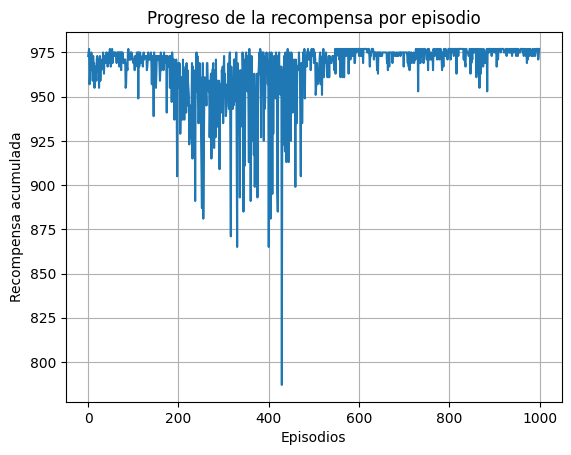

In [8]:
# Visualización del progreso de recompensas
plt.plot(all_rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa acumulada')
plt.title('Progreso de la recompensa por episodio')
plt.grid(True)
plt.show()

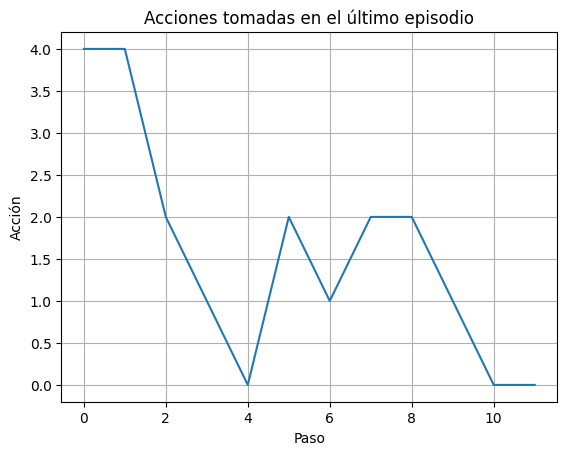

In [9]:
# Visualización de las acciones tomadas en el último episodio
plt.plot(all_actions[-1])
plt.xlabel('Paso')
plt.ylabel('Acción')
plt.title('Acciones tomadas en el último episodio')
plt.grid(True)
plt.show()


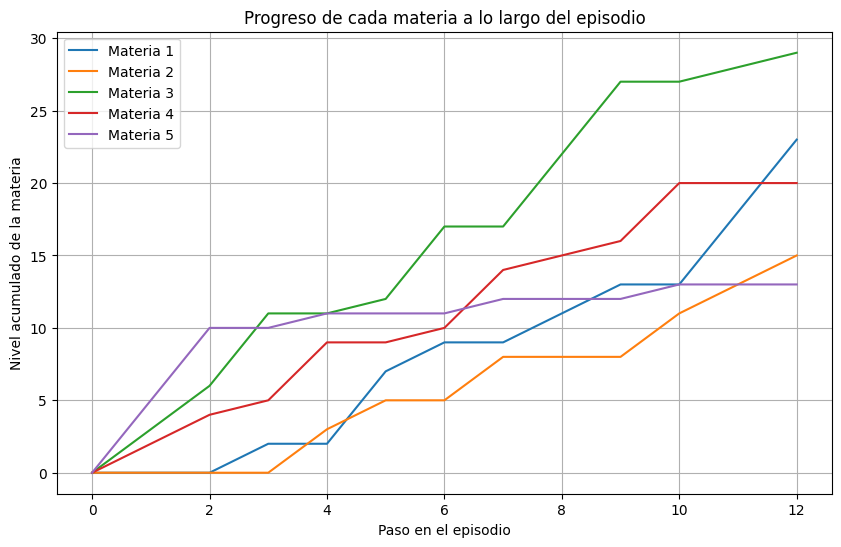

In [10]:
# Array de impacto de actividades
activity_impact = np.array([
    [5, 2, 1, 0, 0], 
    [0, 3, 0, 4, 1], 
    [2, 0, 5, 1, 0], 
    [1, 1, 2, 3, 0], 
    [0, 0, 3, 2, 5]
], dtype=np.int32)

actions = all_actions[-1]
materias = [np.zeros(activity_impact.shape[1], dtype=np.int32)]

for action in actions:
    new_state = materias[-1] + activity_impact[action]
    
    new_state = np.where(materias[-1] >= 100, 100, new_state)
    new_state = np.clip(new_state, 0, 100)
    materias.append(new_state)

materias = np.array(materias)
num_topics = materias.shape[1]  

plt.figure(figsize=(10, 6))
for i in range(num_topics):
    plt.plot(materias[:, i], label=f'Materia {i + 1}')

plt.xlabel('Paso en el episodio')
plt.ylabel('Nivel acumulado de la materia')
plt.title('Progreso de cada materia a lo largo del episodio')
plt.legend()
plt.grid(True)
plt.show()